# Importing Libaries

In [1]:
from data_import import api_request, movie_merger
from data_cleaning import multi_label_one_hot_encoder, data_cleaner
from content_based_system import content_preprocessor, text_preprocessor, create_tf_matrix, top_n_movies_content, top_n_movies_list_content, content_movie_recommender
from performance_metrics import personalisation_score, coverage_score

import numpy as np
import pandas as pd

import json

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacktann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Collection

In [0]:
# importing imdb links
links_df = pd.read_csv("links.csv")

In [0]:
# reformatting imdb ids for api requests
links_df['imdbId'] = links_df['imdbId'].map(lambda x: 'tt{0:07d}'.format(x))
# storing imdb ids
imdb_ids = list(links_df['imdbId'])
# storing api key
api_key = json.load(open(".secret/imdb_api_key.json"))['api_key']

In [0]:
# collecting plots, directors and actors for each movie using api requests
api_request(imdb_ids, api_key, 'api_requests.csv', 0.1)

In [0]:
# merging movies with requests 
movie_merger("movies.csv", "links.csv", 'api_requests.csv', 'movies_full.csv')

files merged


In [0]:
# importing movies
movies_df = pd.read_csv('movies_full.csv').drop(columns = ['Unnamed: 0'])

In [0]:
# previewing movies
movies_df.head()

,movieId,title,actors,director,plot,genres,ageRating
0,1,Toy Story (1995),"Tom Hanks, Tim Allen, Don Rickles, Jim Varney",John Lasseter,A cowboy doll is profoundly threatened and jea...,"Animation, Adventure, Comedy, Family, Fantasy",G
1,2,Jumanji (1995),"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Joe Johnston,When two kids find and play a magical board ga...,"Adventure, Comedy, Family, Fantasy",PG
2,3,Grumpier Old Men (1995),"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Howard Deutch,John and Max resolve to save their beloved bai...,"Comedy, Romance",PG-13
3,4,Waiting to Exhale (1995),"Whitney Houston, Angela Bassett, Loretta Devin...",Forest Whitaker,"Based on Terry McMillan's novel, this film fol...","Comedy, Drama, Romance",R
4,5,Father of the Bride Part II (1995),"Steve Martin, Diane Keaton, Martin Short, Kimb...",Charles Shyer,George Banks must deal not only with the pregn...,"Comedy, Family, Romance",PG


# Data Cleaning

In [0]:
# cleaning movies and ratings
data_cleaner("movies_full.csv", "ratings.csv", "movies_cleaned_and_reduced.csv", "ratings_cleaned_and_reduced.csv")

files cleaned


In [2]:
# importing movies and ratings
movies_df = pd.read_csv('data/movies_cleaned_and_reduced.csv').drop(columns = ['Unnamed: 0'])
ratings_df = pd.read_csv('data/ratings_cleaned_and_reduced.csv').drop(columns = ['Unnamed: 0'])

In [0]:
# previewing movies
movies_df.head(3)

,movieId,title,actors,director,plot,Action,Adult,Adventure,Animation,Biography,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,1,Toy Story,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney",John Lasseter,A cowboy doll is profoundly threatened and jea...,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Joe Johnston,When two kids find and play a magical board ga...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Howard Deutch,John and Max resolve to save their beloved bai...,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [0]:
# previewing ratings
ratings_df.head()

,userId,movieId,rating,timestamp
0,187.0,296,4.5,1.277374e+09
1,548.0,296,4.5,1.431645e+09
2,847.0,296,4.0,1.129271e+09
3,983.0,296,5.0,1.076867e+09
4,997.0,296,5.0,1.529249e+09


# EDA

## How were ratings distributed?

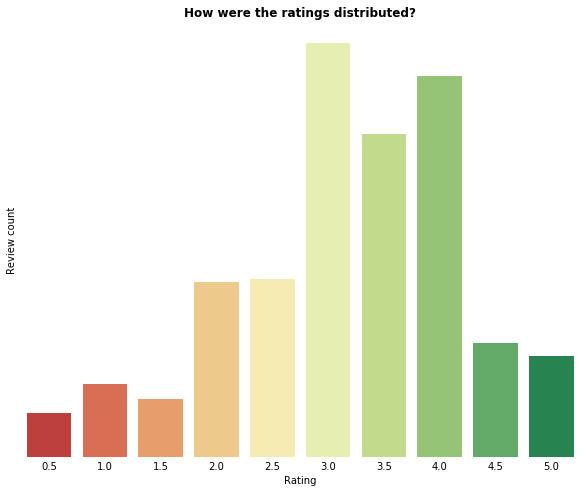

In [0]:
rating_counts = pd.DataFrame(ratings_df['rating'].value_counts()).reset_index()
rating_counts.columns = ['rating', 'review_count']
rating_counts = rating_counts.sort_values('rating', ascending = False)
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'rating', y = 'review_count', data = rating_counts, palette = 'RdYlGn')
ax.set_xticklabels(np.arange(0.5,5.5,0.5))
ax.set_yticks([])
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('How were the ratings distributed?', fontweight = 'bold')
ax.set_xlabel('Rating')
ax.set_ylabel('Review count');

## Were the most popular movies also highly rated?

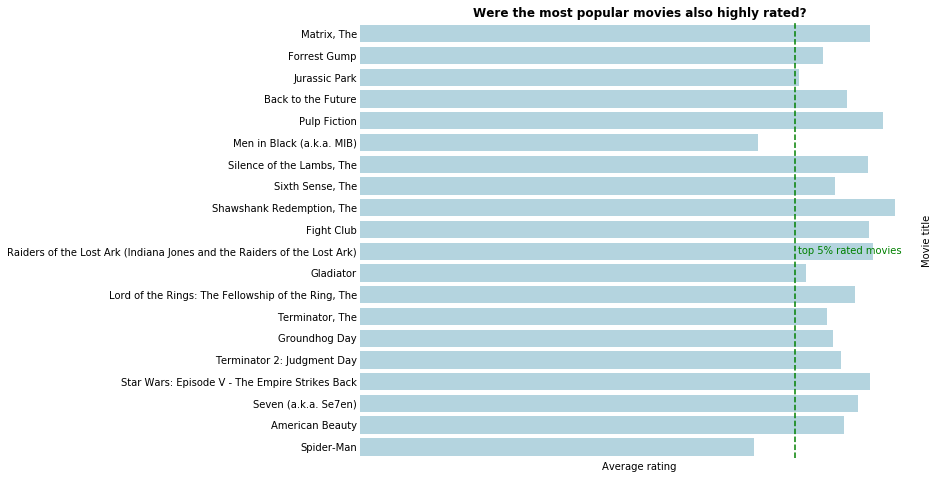

In [0]:
top_movies = ratings_df.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()
top_movies.columns = ['movieId', 'review_count', 'average_rating']
top_movies = pd.merge(top_movies, movies_df, left_on = 'movieId', right_on = 'movieId')[['title', 'review_count', 'average_rating']]
top_movies_sorted = top_movies.sort_values('review_count', ascending = False)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'average_rating', y = 'title', data = top_movies_sorted.head(20), orient = 'h', color = 'lightblue')
top_5_percent_line = top_movies_sorted['average_rating'].quantile(0.95)
ax.axvline(top_5_percent_line, color = 'green', ls = '--')
ax.text(top_5_percent_line + 0.02, 10.1,'top 5% rated movies', color = 'green')
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_xticks([])
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlim([1, 4.5])
ax.set_title('Were the most popular movies also highly rated?', fontweight = 'bold')
ax.set_xlabel('Average rating')
ax.set_ylabel('Movie title');

## What were the most popular movie genres?

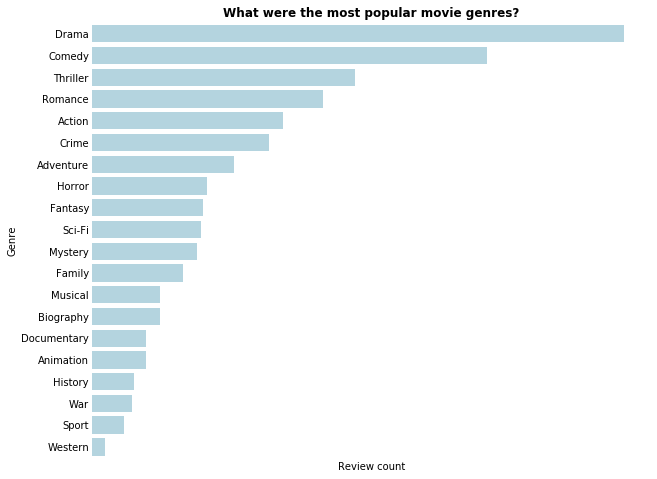

In [0]:
genre_counts = pd.DataFrame(movies_df.drop(columns = ['movieId', 'title', 'director', 'actors', 'plot']).sum()).reset_index()
genre_counts.columns = ['genre', 'review_count']
sorted_genre_counts = genre_counts.sort_values('review_count', ascending = False)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'review_count', y = 'genre', data = sorted_genre_counts.head(20), orient = 'h', color = 'lightblue')
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('What were the most popular movie genres?', fontweight = 'bold')
ax.set_xlabel('Review count')
ax.set_ylabel('Genre');

## Were the most active users hardest to please?

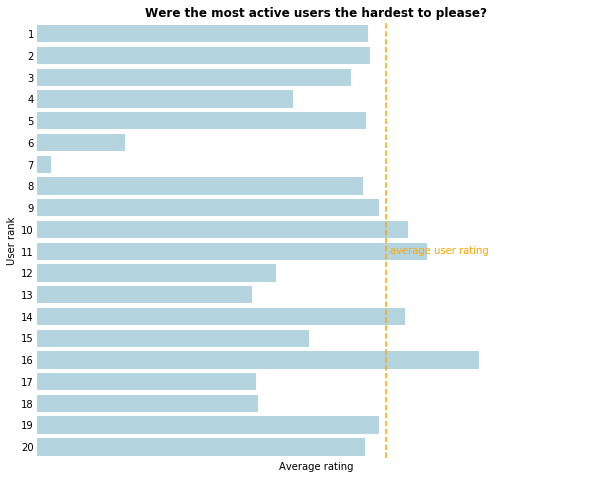

In [0]:
top_users = ratings_df.groupby('userId')['rating'].agg(['count', 'mean']).reset_index()
top_users.columns = ['userId', 'review_count', 'average_rating']
top_users_sorted = top_users.sort_values('review_count', ascending = False)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'average_rating', y = 'userId', data = top_users_sorted.head(20), orient = 'h', color = 'lightblue')
mean_line = top_users_sorted['average_rating'].mean()
ax.axvline(mean_line, color = 'orange', ls = '--')
ax.text(mean_line + 0.02, 10.1,'average user rating', color = 'orange')
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_xticks([])
ax.set_yticklabels(range(1,21))
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlim([1, 4.5])
ax.set_title('Were the most active users the hardest to please?', fontweight = 'bold')
ax.set_xlabel('Average rating')
ax.set_ylabel('User rank');

# Modelling

## Content-based model

### Movies without plots

In [0]:
# pre-processing movies for content-based system
content_preprocessor('movies_cleaned_and_reduced.csv', 'preprocessed_content.csv')

file processed


In [3]:
# importing preprocessed movies, without plots
content_df = pd.read_csv('data/preprocessed_content.csv').drop(columns = 'Unnamed: 0')

In [4]:
content_df.head(3)

,title,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Todd Phillips,Tony Scott,Walter Hill,Werner Herzog.1,Wes Craven,William Friedkin,Wim Wenders,Wolfgang Petersen,Woody Allen.1,Yimou Zhang
0,Toy Story,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# converting preprocessed movie dataframe into a matrix
tf_matrix = np.array(content_df.drop(columns = ['title']))
# storing the top 20 recommendations for the first 1000 movies
top_n_movies_without_plots = top_n_movies_list_content(tf_matrix, 20)[:1000]

In [8]:
# calculating personalisation score for first 1000 movies
round(personalisation_score(top_n_movies_without_plots), 3)

0.98

In [9]:
# calculating coverage score for first 1000 movies
round(coverage_score(top_n_movies_without_plots, content_df['title']), 3)

0.391

### Movies with plots

In [0]:
# preprocessing plots
plot_tokens = movies_df['plot'].map(lambda x: text_preprocessor(x))

In [0]:
# one-hot encoding plot tokens
tf_matrix_all, all_features = create_tf_matrix(plot_tokens)

In [0]:
# initial number of tokens
tf_matrix_all.shape[1]

8415

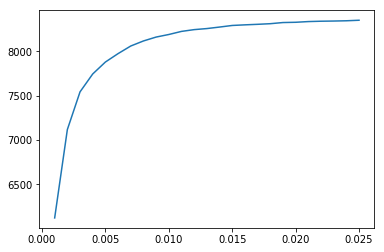

In [0]:
# choosing a maximum token frequency
max_freqs = list(np.arange(0.001, 0.02505, 0.001))
n_tokens = []
for freq in max_freqs:
    tf_matrix, features = create_tf_matrix(plot_tokens, max_freq = freq)
    n_tokens.append(tf_matrix.shape[1])

plt.plot(max_freqs, n_tokens);
# number of tokens stagnates beyond a maximum token frequency of 0.005

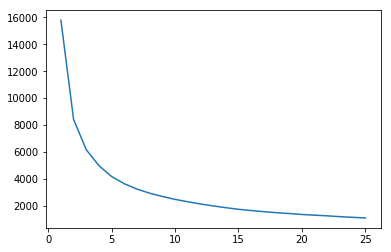

In [0]:
# choosing a minimum token frequency
min_freqs = list(range(1,26))
n_tokens = []
for freq in min_freqs:
    tf_matrix, features = create_tf_matrix(plot_tokens, min_freq = freq)
    n_tokens.append(tf_matrix.shape[1])
    
plt.plot(min_freqs, n_tokens);
# number of tokens stagnates beyond a minimum token frequency of 5

In [0]:
# reduced number of tokens
tf_matrix_reduced, features_reduced = create_tf_matrix(plot_tokens, min_freq = 5, max_freq = 0.005)
tf_matrix_reduced.shape[1]

3634

In [0]:
# normalising the reduced, one-hot encoded plots
norm_matrix_reduced = normalize(tf_matrix_reduced, axis = 1, norm = 'l1')
# merging normalised plots with genres, actors and directors
plot_tokens_df = pd.DataFrame(norm_matrix_reduced.toarray(), columns = features_reduced)
content_with_plots_df = pd.concat([content_df, plot_tokens_df], axis = 1)
# saving preprocessed movies, with plots
content_with_plots_df.to_csv('preprocessed_content_with_plots.csv')

In [10]:
# importing preprocessed movies, with plots
content_with_plots_df = pd.read_csv('data/preprocessed_content_with_plots.csv')

In [15]:
# converting preprocessed movie dataframe into a matrix
tf_matrix_with_plots = np.array(content_with_plots_df.drop(columns = ['title']))
# storing the top 20 recommendations for the first 1000 movies
top_n_movies_with_plots = top_n_movies_list_content(tf_matrix_with_plots, 20)[:1000]

In [0]:
# calculating personalisation score for first 1000 movies
round(personalisation_score(top_n_movies_with_plots), 3)

In [0]:
# calculating coverage score for first 1000 movies
round(coverage_score(top_n_movies_with_plots, content_df['title']), 3)

### Outputting movie recommendations

In [0]:
# cycling through top 5 recommendations for different movies
content_movie_recommender(content_df, tf_matrix, 0, 5)

Users who like:
Toy Story

Will also like:
Toy Story 4
Toy Story That Time Forgot
Toy Story 2
Toy Story 3
SpongeBob SquarePants Movie, The



## Matrix factorisation model

### Creating Spark context

In [0]:
# installing Java, Spark and FindSpark libaries
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz  
!pip install -q findspark

In [0]:
# setting environment variables for Java and Spark downloads
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
# initialising FindSpark
import findspark
findspark.init()

In [0]:
# creating local Spark context
from pyspark import SparkContext
sc = SparkContext("local")
# sc.stop()

### Training baseline matrix factorisation model

In [0]:
# creating rdd object for parallel processing of ratings
%time rdd = create_rdd(ratings_df)

CPU times: user 2min 9s, sys: 409 ms, total: 2min 9s
Wall time: 2min 10s


In [0]:
# train test split
train_set, test_set = rdd.randomSplit([0.99, 0.01], 1)

In [0]:
# training baseline matrix factorisation model
base_model, base_rmse = train_MF_model(train_set, test_set)

In [0]:
# calculating rmse for baseline matrix factorisation model
round(base_rmse, 3)

0.75

### Hyperparameter tuning

In [0]:
# creater smaller rdd object for hyperparameter tuning
rdd_small = create_rdd(ratings_df[:250000])
train_set_small, test_set_small = rdd_small.randomSplit([0.99, 0.01], 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Tuning the number of embeddings

In [0]:
n_embeddings = list(range(1,27, 2))
rmses = []
for n in n_embeddings:
  rmse = train_MF_model(train_set_small, test_set_small, n)[1]
  print("n_embeddings = {}, rmse = {}".format(n, round(rmse, 3)))
  rmses.append(rmse)

n_embeddings = 1, rmse = 0.856
n_embeddings = 3, rmse = 0.791
n_embeddings = 5, rmse = 0.769
n_embeddings = 7, rmse = 0.737
n_embeddings = 9, rmse = 0.727
n_embeddings = 11, rmse = 0.725
n_embeddings = 13, rmse = 0.726
n_embeddings = 15, rmse = 0.719
n_embeddings = 17, rmse = 0.722
n_embeddings = 19, rmse = 0.735
n_embeddings = 21, rmse = 0.729
n_embeddings = 23, rmse = 0.731
n_embeddings = 25, rmse = 0.733


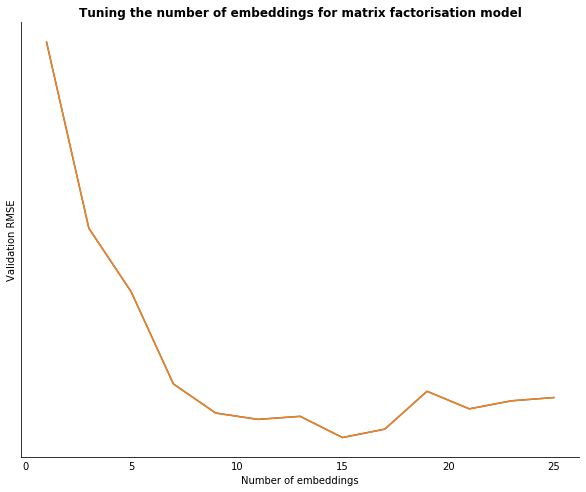

In [0]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
ax.plot(n_embeddings, rmses)
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Tuning the number of embeddings for matrix factorisation model', fontweight = 'bold')
ax.set_xlabel('Number of embeddings')
ax.set_ylabel('Validation RMSE');
plt.plot(n_embeddings, rmses);

#### Tuning the regularisation parameter

In [0]:
reg_params = list(np.arange(0.01, 0.27, 0.02))
rmses_2 = []
for param in reg_params:
  rmse = train_MF_model(train_set_small, test_set_small, 10, reg_param = param)[1]
  print("lambda = {}, rmse = {}".format(round(param, 2), round(rmse, 3)))
  rmses_2.append(rmse)

lambda = 0.01, rmse = 0.731
lambda = 0.03, rmse = 0.738
lambda = 0.05, rmse = 0.757
lambda = 0.07, rmse = 0.776
lambda = 0.09, rmse = 0.796
lambda = 0.11, rmse = 0.816
lambda = 0.13, rmse = 0.831
lambda = 0.15, rmse = 0.841
lambda = 0.17, rmse = 0.846
lambda = 0.19, rmse = 0.851
lambda = 0.21, rmse = 0.857
lambda = 0.23, rmse = 0.863
lambda = 0.25, rmse = 0.867


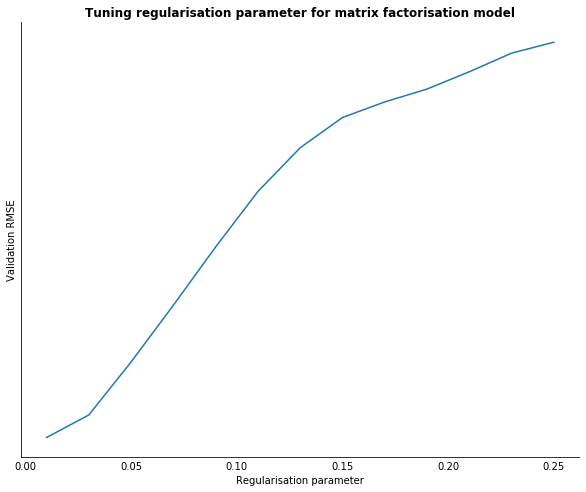

In [0]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
ax.plot(reg_params, rmses_2)
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Tuning regularisation parameter for matrix factorisation model', fontweight = 'bold')
ax.set_xlabel('Regularisation parameter')
ax.set_ylabel('Validation RMSE');

### Training and validating tuned matrix factorisation model

In [0]:
# training tuned matrix factorisation model
tuned_model, tuned_rmse = train_MF_model(rdd, test_set, 15, n_iterations = 10)

In [0]:
# calculating rmse for tuned matrix factorisation model
round(tuned_rmse, 3)

0.671

In [0]:
# saving tuned matrix factorisation model
tuned_model.save(sc, 'MF_tuned_model.model')

In [0]:
# zipping model object for download
!zip -r MF_tuned_model.zip MF_tuned_model.model

  adding: MF_tuned_model.model/ (stored 0%)
  adding: MF_tuned_model.model/metadata/ (stored 0%)
  adding: MF_tuned_model.model/metadata/._SUCCESS.crc (stored 0%)
  adding: MF_tuned_model.model/metadata/.part-00000.crc (stored 0%)
  adding: MF_tuned_model.model/metadata/part-00000 (deflated 8%)
  adding: MF_tuned_model.model/metadata/_SUCCESS (stored 0%)
  adding: MF_tuned_model.model/data/ (stored 0%)
  adding: MF_tuned_model.model/data/product/ (stored 0%)
  adding: MF_tuned_model.model/data/product/._SUCCESS.crc (stored 0%)
  adding: MF_tuned_model.model/data/product/_SUCCESS (stored 0%)
  adding: MF_tuned_model.model/data/product/.part-00000-f6430096-c94a-467c-ae68-4e3d96e4f95a-c000.snappy.parquet.crc (stored 0%)
  adding: MF_tuned_model.model/data/product/part-00000-f6430096-c94a-467c-ae68-4e3d96e4f95a-c000.snappy.parquet (deflated 21%)
  adding: MF_tuned_model.model/data/user/ (stored 0%)
  adding: MF_tuned_model.model/data/user/._SUCCESS.crc (stored 0%)
  adding: MF_tuned_model.

In [0]:
# loading tuned matrix factorisation model
tuned_model = MatrixFactorizationModel.load(sc, "MF_tuned_model.model")

In [0]:
# storing unique user and movie ids
unique_users = np.unique(ratings_df['userId'].astype('int'))
unique_movies = np.unique(movies_df['movieId'])

In [0]:
# storing the top 20 recommendations for the first 1000 users
%time top_n_movies_list = top_n_movies_list_mf(tuned_model, unique_users, 20)

CPU times: user 1.6 s, sys: 370 ms, total: 1.97 s
Wall time: 55.8 s


In [0]:
# calculating personalisation score for first 1000 users
personalisation_score(top_n_movies_list)

0.8941220256953373

In [0]:
# calculating coverage score for first 1000 users
coverage_score(top_n_movies_list, unique_movies)

0.1348

## Nueral network model

In [0]:
from keras import models, layers, optimizers, initializers, Model

Using TensorFlow backend.


In [0]:
# storing user ids, movie ids and ratings
users = np.array(ratings_df['userId'].astype('int'))
movies = np.array(ratings_df['movieId'])
ratings = np.array(ratings_df['rating'])
# reshaping user ids, movie ids and ratings for nueral network
users_input = users.reshape(-1,1)
movies_input = movies.reshape(-1,1)
ratings_output = ratings.reshape(-1,1,1) / 5
# storing maximum user id and movie id
max_user_id = users.max()
max_movie_id = movies.max()

In [0]:
def create_nn(max_user_id, max_movie_id, n_embeddings = 5,  n_hidden_layers = 1, n_hidden_units = 5):
    # input layers for users and movies
    users = layers.Input(shape = (1,))
    movies = layers.Input(shape = (1,))
    # embedding layers for users and movies
    embeddings_init = initializers.RandomUniform(minval = -1, maxval = 1, seed = 1)
    user_embeddings = layers.Embedding(max_user_id + 1, n_embeddings, input_length = 1, embeddings_initializer = embeddings_init)(users)
    movie_embeddings = layers.Embedding(max_movie_id + 1, n_embeddings, input_length = 1, embeddings_initializer = embeddings_init)(movies)
    # element-wise dot product between embeddings
    dot_product = layers.multiply([user_embeddings, movie_embeddings])
    # hidden layer, with relu activation
    hidden_layer = layers.Dense(n_hidden_units, activation = "relu")(dot_product)
    # extra hidden layers, with relu activation
    if n_hidden_layers > 1:
        n_layers_left = n_hidden_layers - 1
        while n_layers_left > 0:
            hidden_layer = layers.Dense(n_hidden_units, activation = "relu")(hidden_layer)
            n_layers_left -= 1
    # output layer with sigmoid activation
    output = layers.Dense(1, activation = "sigmoid")(hidden_layer)
    # defining network architecture
    network = Model(inputs = [users, movies], outputs = [output])
    # compiling network
    network.compile('rmsprop','mse')
    return network

In [0]:
def train_nn(network, train_users, train_movies, train_ratings, batch_size = 256, n_epochs = 10):
    # training compiled network, with a pre-defined batch size and number of epochs
    history = network.fit([train_users, train_movies], train_ratings, batch_size = batch_size, epochs = n_epochs, verbose = 1)
    return history

In [0]:
# training baseline nueral network model
base_network = create_nn(max_user_id, max_movie_id)
history = train_nn(base_network, users_input, movies_input, ratings_output)

/Users/jacktann/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
Epoch 1/10
2618325/2618325 [==============================] - 295s 113us/step - loss: 0.0361
Epoch 2/10
2618325/2618325 [==============================] - 295s 113us/step - loss: 0.0294
Epoch 3/10
2618325/2618325 [==============================] - 300s 115us/step - loss: 0.0284
Epoch 4/10
2618325/2618325 [==============================] - 299s 114us/step - loss: 0.0277
Epoch 5/10
2618325/2618325 [==============================] - 280s 107us/step - loss: 0.0271
Epoch 6/10
2618325/2618325 [==============================] - 278s 106us/step - loss: 0.0266
Epoch 7/10
2618325/2618325 [==============================] - 275s 105us/step - loss: 0.0262
Epoch 8/10
2618325/2618325 [==============

In [0]:
def top_n_movies_nn(network, user, movies, n_rec):
    user_input = user.reshape(1,1)
    movies_input = movies.reshape(-1,1)
    predicted_user_ratings = []
    for movie_input in movies_input:
        predicted_user_ratings.append(network.predict([user_input, movie_input])[0][0][0])
    predicted_user_ratings = list(zip(movies, predicted_user_ratings))
    sorted_user_ratings = sorted(predicted_user_ratings, key = lambda rating: rating[1], reverse = True)[:n_rec]
    sorted_movie_indices = [rating[0] for rating in sorted_user_ratings]
    return sorted_movie_indices

In [0]:
def top_n_movies_list_nn(network, users, movies, n_rec):
    top_n_movies_list = []
    for user in users:  
        sorted_movie_indices = top_n_movies_nn(network, user, movies, n_rec)
        sorted_movie_tokens = ['movie' + str(movie) for movie in sorted_movie_indices]
        top_n_movies_list.append(sorted_movie_tokens)
    return top_n_movies_list

In [0]:
unique_users = np.unique(users)
unique_movies = np.unique(movies)
top_n_movies_list = top_n_movies_list_nn(base_network, unique_users[:1000], unique_movies[:1000], 10)

In [0]:
# calculating personalisation score for first 1000 users
round(personalisation_score(top_n_movies_list), 3)

0.597

In [0]:
# calculating coverage score for first 1000 users
round(coverage_score(top_n_movies_list, movies[:1000]), 3)

0.271